In [17]:
import pandas as pd
import numpy as np
from sklearn import datasets

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.stats import norm
import statistics 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
iris = datasets.load_iris()

X = iris['data']
y = iris['target']

df = pd.DataFrame(X)
df['Class'] = y

df.columns=['F1', 'F2', 'F3', 'F4', 'Class']

In [3]:
df

,F1,F2,F3,F4,Class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


# NN

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from sklearn.metrics import accuracy_score

In [5]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_encoded = pd.get_dummies(y_train)

In [6]:
model = Sequential()

model.add(Dense(36, activation='tanh')) # input size is the total num_clusters from each dimension
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

# fit network
history = model.fit(X_train, y_encoded, epochs=100, validation_split = 0.2, verbose=2, callbacks = [early_stopping_callback])

Epoch 1/100
3/3 - 1s - loss: 0.6793 - accuracy: 0.3542 - val_loss: 0.6610 - val_accuracy: 0.2917
Epoch 2/100
3/3 - 0s - loss: 0.6604 - accuracy: 0.3542 - val_loss: 0.6435 - val_accuracy: 0.2917
Epoch 3/100
3/3 - 0s - loss: 0.6445 - accuracy: 0.3542 - val_loss: 0.6298 - val_accuracy: 0.2917
Epoch 4/100
3/3 - 0s - loss: 0.6326 - accuracy: 0.3542 - val_loss: 0.6181 - val_accuracy: 0.2917
Epoch 5/100
3/3 - 0s - loss: 0.6233 - accuracy: 0.3542 - val_loss: 0.6099 - val_accuracy: 0.2917
Epoch 6/100
3/3 - 0s - loss: 0.6149 - accuracy: 0.3542 - val_loss: 0.6021 - val_accuracy: 0.2917
Epoch 7/100
3/3 - 0s - loss: 0.6075 - accuracy: 0.3542 - val_loss: 0.5964 - val_accuracy: 0.2917
Epoch 8/100
3/3 - 0s - loss: 0.6009 - accuracy: 0.3646 - val_loss: 0.5879 - val_accuracy: 0.3333
Epoch 9/100
3/3 - 0s - loss: 0.5944 - accuracy: 0.4375 - val_loss: 0.5803 - val_accuracy: 0.5417
Epoch 10/100
3/3 - 0s - loss: 0.5882 - accuracy: 0.5417 - val_loss: 0.5748 - val_accuracy: 0.7500
Epoch 11/100
3/3 - 0s - loss:

In [7]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis = 1)

In [8]:
accuracy_score(y_test, y_pred)

1.0

# Layer 1: Creating Memberships

In [9]:
def k_distance_plot(data, nn):

  neigh = NearestNeighbors(n_neighbors=nn)
  nbrs = neigh.fit(data)
  distances, indices = nbrs.kneighbors(data)

  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.figure(figsize=(10,8))
  plt.plot(distances)
  plt.title('K-distance Graph',fontsize=15)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()

In [10]:
# Functions to get the gaussian projections of all clusters on one specific axis

# Gets the datapoints and centroid coordinates for a particular cluster
def get_data_centroid(X, y_pred, cluster_label):
    datapoints = X[y_pred==cluster_label,:]
    centroid_coord = np.mean(datapoints, axis=0) 
    return datapoints, centroid_coord

# Gets the mean and std of a particular cluster (for 1 dimension only)
def mean_std(cluster_data, dim):
    points = cluster_data[:,dim]
    return statistics.mean(points), statistics.stdev(points)

# Gets the data required for each dimension (for all clusters)
def get_dimension_dict(X, num_clusters, dim, y_pred):
    dim_dict = {}
    
    for i in range(num_clusters):
        dim_dict["cluster"+str(i)] = {}
        data, centroid = get_data_centroid(X, y_pred, i)
        data_mean, data_std = mean_std(data, dim)
        dim_dict["cluster"+str(i)]["data"] = data
        dim_dict["cluster"+str(i)]["centroid"] = centroid
        dim_dict["cluster"+str(i)]["mean"] = data_mean
        dim_dict["cluster"+str(i)]["std"] = data_std
        
    return dim_dict

# Plot the gaussian projections of each cluster on the specified dimension
def plot_projection(dim_dict, num_clusters, title):
    
    plt.subplot(1,1,1)
    plt.title(title)
    for i in range(num_clusters):
        mean = dim_dict["cluster"+str(i)]["mean"]
        std = dim_dict["cluster"+str(i)]["std"]
        x = np.linspace(mean - 6*std, mean+6*std, 100)
        y = norm.pdf(x, mean, std)
        plt.plot(x, y/max(y), label="Cluster #"+str(i))
        
    plt.legend(bbox_to_anchor=(1.35, 0.7))

In [11]:
def dimension_projection(data, y_pred, title, dim):
  num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
  num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
  print('Number of noise points: ', num_outliers)
  print("Number of clusters: ", num_clusters)

  unique = pd.DataFrame(np.unique(y_pred, return_counts = True))
  print("Unqiue Clusters: ")
  display(unique)

  print("Centroids: ")
  for i in range(num_clusters):
      print("centroid", str(i), ": ", get_data_centroid(data, y_pred, i)[1])
      
  dim_dict = get_dimension_dict(data, num_clusters, dim, y_pred)
  plot_projection(dim_dict, num_clusters, title)

  return num_clusters, dim_dict

In [12]:
def output_fuzzy_memberships(dim_dict, num_clusters, dim_data_pt):
    fuzzy_memberships = []
    for i in range(num_clusters):
        mean = dim_dict["cluster"+str(i)]["mean"]
        std = dim_dict["cluster"+str(i)]["std"]
        pdf = norm(mean, std).pdf(dim_data_pt)
        max_y = norm(mean, std).pdf(mean)
        fuzzy_memberships.append(pdf/max_y)
      
    # max_membership = max(fuzzy_memberships)
    # index = fuzzy_memberships.index(max_membership)
    return fuzzy_memberships

In [13]:
index = 0
data1 = df.iloc[index, :-1]
data1

F1    5.1
F2    3.5
F3    1.4
F4    0.2
Name: 0, dtype: float64

In [14]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# y_encoded = pd.get_dummies(y_train)

# F1 DBSCAN

In [15]:
F1 = df[['F1']].values

Number of noise points:  1
Number of clusters:  2
Unqiue Clusters: 


,0,1,2
0,-1,0,1
1,1,144,5


Centroids: 
centroid 0 :  [5.76527778]
centroid 1 :  [7.68]


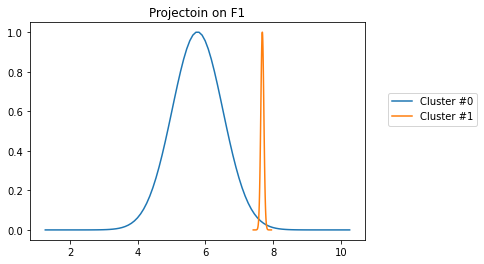

In [18]:
dbscan = DBSCAN(eps=0.15, min_samples=5).fit(F1)
y_pred = dbscan.labels_

num_clusters, dim_dict = dimension_projection(F1, y_pred, "Projection on F1", 0)

In [19]:
output_fuzzy_memberships(dim_dict, num_clusters, data1[0])

[0.6739162894232449, 0.0]

In [20]:
train_F1_data = list(X_train.iloc[:, 0])
test_F1_data = list(X_test.iloc[:, 0])

train_F1_fuzzified = []
for i in train_F1_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  train_F1_fuzzified.append(fuzzified)

test_F1_fuzzified = []
for i in test_F1_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  test_F1_fuzzified.append(fuzzified)

# F2 DBSCAN

In [21]:
F2 = df[['F2']].values

Number of noise points:  0
Number of clusters:  1
Unqiue Clusters: 


,0
0,0
1,150


Centroids: 
centroid 0 :  [3.05733333]


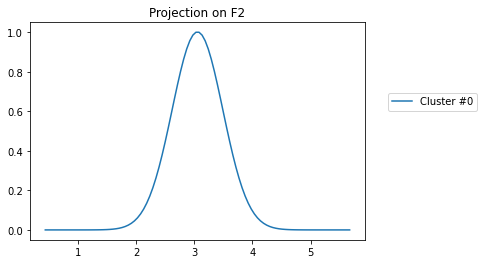

In [22]:
dbscan = DBSCAN(eps=2.5, min_samples=5).fit(F2)
y_pred = dbscan.labels_

num_clusters, dim_dict = dimension_projection(F2, y_pred, "Projection on F2", 0)

In [23]:
output_fuzzy_memberships(dim_dict, num_clusters, data1[1])

[0.5970683388109018]

In [24]:
train_F2_data = list(X_train.iloc[:, 1])
test_F2_data = list(X_test.iloc[:, 1])

train_F2_fuzzified = []
for i in train_F2_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  train_F2_fuzzified.append(fuzzified)

test_F2_fuzzified = []
for i in test_F2_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  test_F2_fuzzified.append(fuzzified)

# F3 DBSCAN

In [30]:
F3 = df[['F3']].values

Number of noise points:  9
Number of clusters:  2
Unqiue Clusters: 


,0,1,2
0,-1,0,1
1,9,50,91


Centroids: 
centroid 0 :  [1.462]
centroid 1 :  [4.85054945]


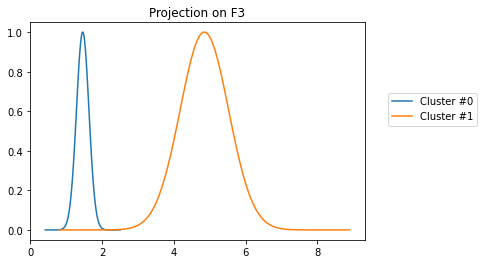

In [31]:
dbscan = DBSCAN(eps=0.2, min_samples=5).fit(F3)
y_pred = dbscan.labels_

num_clusters, dim_dict = dimension_projection(F3, y_pred, "Projection on F3", 0)

In [32]:
output_fuzzy_memberships(dim_dict, num_clusters, data1[2])

[0.9382596880501617, 2.0768786892443653e-06]

In [33]:
train_F3_data = list(X_train.iloc[:, 2])
test_F3_data = list(X_test.iloc[:, 2])

train_F3_fuzzified = []
for i in train_F3_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  train_F3_fuzzified.append(fuzzified)

test_F3_fuzzified = []
for i in test_F3_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  test_F3_fuzzified.append(fuzzified)

# F4 DBSCAN

In [34]:
F4 = df[['F4']].values

Number of noise points:  0
Number of clusters:  1
Unqiue Clusters: 


,0
0,0
1,150


Centroids: 
centroid 0 :  [1.19933333]


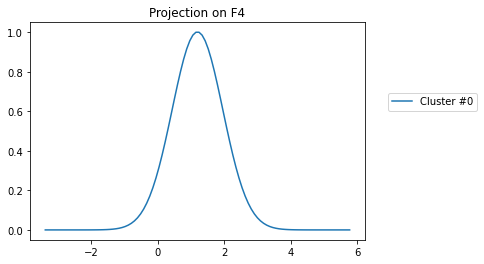

In [35]:
dbscan = DBSCAN(eps=2.5, min_samples=5).fit(F4)
y_pred = dbscan.labels_

num_clusters, dim_dict = dimension_projection(F4, y_pred, "Projection on F4", 0)

In [36]:
output_fuzzy_memberships(dim_dict, num_clusters, data1[3])

[0.423403832898659]

In [37]:
train_F4_data = list(X_train.iloc[:, 3])
test_F4_data = list(X_test.iloc[:, 3])

train_F4_fuzzified = []
for i in train_F4_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  train_F4_fuzzified.append(fuzzified)

test_F4_fuzzified = []
for i in test_F4_data:
  fuzzified = output_fuzzy_memberships(dim_dict, num_clusters, i)
  test_F4_fuzzified.append(fuzzified)

# Layer 2: Fuzzification of inputs

In [38]:
train_all_fuzzified = []
for i in range(len(train_F1_fuzzified)):
  one_data = []
  one_data.extend(train_F1_fuzzified[i])
  one_data.extend(train_F2_fuzzified[i])
  one_data.extend(train_F3_fuzzified[i])
  one_data.extend(train_F4_fuzzified[i])
  train_all_fuzzified.append(one_data)

test_all_fuzzified = []
for i in range(len(test_F1_fuzzified)):
  one_data = []
  one_data.extend(test_F1_fuzzified[i])
  one_data.extend(test_F2_fuzzified[i])
  one_data.extend(test_F3_fuzzified[i])
  one_data.extend(test_F4_fuzzified[i])
  test_all_fuzzified.append(one_data)

# Layer 3: Into Deep NN

In [39]:
y_encoded = pd.get_dummies(y_train)

In [40]:
X_train_fuzzified = pd.DataFrame(train_all_fuzzified)
X_test_fuzzified = pd.DataFrame(test_all_fuzzified)

In [41]:
X_train_fuzzified

,0,1,2,3,4,5
0,0.297966,0.000000e+00,0.460681,2.905329e-02,8.386003e-08,0.423404
1,0.996208,0.000000e+00,0.008699,9.763446e-01,4.385422e-06,0.577036
2,0.458837,5.319795e-105,0.995220,7.086031e-63,8.000469e-01,0.965941
3,0.435689,0.000000e+00,0.734155,7.292602e-01,9.058704e-06,0.423404
4,0.189747,0.000000e+00,0.947841,6.472055e-01,9.622001e-07,0.423404
...,...,...,...,...,...,...
115,0.904926,9.053445e-272,0.840059,4.181810e-47,4.515668e-01,0.991317
116,0.512938,0.000000e+00,0.441529,3.529075e-67,8.736751e-01,0.805962
117,0.998926,0.000000e+00,0.096450,3.204503e-01,4.360880e-07,0.423404
118,0.998926,0.000000e+00,0.576682,4.181810e-47,4.515668e-01,1.000000


In [66]:
model = Sequential()

model.add(Dense(36, activation='tanh')) # input size is the total num_clusters from each dimension
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 10)

# fit network
history = model.fit(X_train_fuzzified, y_encoded, epochs=100, validation_split = 0.1, verbose=2)

Epoch 1/100
4/4 - 0s - loss: 1.0198 - accuracy: 0.5741 - val_loss: 1.0159 - val_accuracy: 0.4167
Epoch 2/100
4/4 - 0s - loss: 0.9907 - accuracy: 0.6111 - val_loss: 0.9943 - val_accuracy: 0.5000
Epoch 3/100
4/4 - 0s - loss: 0.9609 - accuracy: 0.6019 - val_loss: 0.9728 - val_accuracy: 0.5833
Epoch 4/100
4/4 - 0s - loss: 0.9299 - accuracy: 0.6111 - val_loss: 0.9520 - val_accuracy: 0.6667
Epoch 5/100
4/4 - 0s - loss: 0.8992 - accuracy: 0.6389 - val_loss: 0.9299 - val_accuracy: 0.6667
Epoch 6/100
4/4 - 0s - loss: 0.8663 - accuracy: 0.6759 - val_loss: 0.9032 - val_accuracy: 0.8333
Epoch 7/100
4/4 - 0s - loss: 0.8343 - accuracy: 0.7037 - val_loss: 0.8759 - val_accuracy: 0.8333
Epoch 8/100
4/4 - 0s - loss: 0.8032 - accuracy: 0.7315 - val_loss: 0.8522 - val_accuracy: 0.7500
Epoch 9/100
4/4 - 0s - loss: 0.7711 - accuracy: 0.7500 - val_loss: 0.8272 - val_accuracy: 0.7500
Epoch 10/100
4/4 - 0s - loss: 0.7413 - accuracy: 0.7500 - val_loss: 0.8026 - val_accuracy: 0.7500
Epoch 11/100
4/4 - 0s - loss:

In [67]:
y_pred_probs = model.predict(X_test_fuzzified)
y_pred = np.argmax(y_pred_probs, axis = 1)

In [68]:
accuracy_score(y_test, y_pred)

0.9666666666666667

In [69]:
pd.DataFrame({"Actual" : y_test, 
              "Predicted" : y_pred})

,Actual,Predicted
73,1,1
18,0,0
118,2,2
78,1,1
76,1,1
31,0,0
64,1,1
141,2,2
68,1,1
82,1,1
